In [1]:
import os

# Đường dẫn thư mục input
input_dir = '/kaggle/input/encoding-image-and-testing'

# Biến đếm ảnh và tìm file pkl
image_count = 0
feature_vector_path = None

# Duyệt qua tất cả các file
for root, dirs, files in os.walk(input_dir):
    for file in files:
        # Đếm ảnh dựa vào phần mở rộng
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_count += 1
        # Tìm file feature_vectors.pkl
        if file == 'feature_vectors.pkl':
            feature_vector_path = os.path.join(root, file)

# Kết quả
print(f"Tổng số ảnh: {image_count}")
if feature_vector_path:
    print(f"Đã tìm thấy file feature_vectors.pkl tại: {feature_vector_path}")
else:
    print("Không tìm thấy file feature_vectors.pkl")


Tổng số ảnh: 31395
Đã tìm thấy file feature_vectors.pkl tại: /kaggle/input/encoding-image-and-testing/feature_vectors.pkl


In [2]:
import os
import glob
import random
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# ==== Dataset Class ====
class TripletDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(data_dir, "*.jpg"))
        self.class_to_images = {}

        for path in self.image_paths:
            cls = os.path.basename(path).split("_")[0]
            self.class_to_images.setdefault(cls, []).append(path)

        self.classes = list(self.class_to_images.keys())

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        anchor_class = random.choice(self.classes)
        positive_class = anchor_class
        negative_class = random.choice([cls for cls in self.classes if cls != anchor_class])

        anchor, positive = random.sample(self.class_to_images[anchor_class], 2)
        negative = random.choice(self.class_to_images[negative_class])

        anchor_img = Image.open(anchor).convert("RGB")
        positive_img = Image.open(positive).convert("RGB")
        negative_img = Image.open(negative).convert("RGB")

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

# ==== Embedding Network ====
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        base = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.fc = nn.Linear(2048, 256)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

# ==== Triplet Loss ====
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    return torch.relu(pos_dist - neg_dist + margin).mean()

# ==== Train Function ====
def train_embedding_model(data_dir, batch_size=32, epochs=5, lr=1e-4, output_path="resnet50_triplet.pth"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = TripletDataset(data_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EmbeddingNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for anchor, pos, neg in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
            out_a = model(anchor)
            out_p = model(pos)
            out_n = model(neg)

            loss = triplet_loss(out_a, out_p, out_n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), output_path)
    print(f"✅ Model saved to: {output_path}")
    return model


In [3]:
#train_embedding_model("/kaggle/input/encoding-image-and-testing/cropped_images",batch_size=54, epochs=70, lr=1e-4,)


In [4]:
pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
import faiss
import matplotlib.pyplot as plt

# === EmbeddingNet khớp với model đã train ===
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        base = models.resnet50(pretrained=False)
        self.backbone = nn.Sequential(*list(base.children())[:-1])
        self.fc = nn.Linear(2048, 256)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

# === Load model đã huấn luyện ===
def load_trained_model(weight_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EmbeddingNet().to(device)
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    return model, device

# === Encode toàn bộ ảnh thành vector đặc trưng ===
def encode_images_in_folder(model, device, folder):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    
    image_names = []
    vectors = []

    for img_name in tqdm(os.listdir(folder), desc="Encoding images"):
        if not img_name.lower().endswith('.jpg'):
            continue
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            vector = model(img_tensor).cpu().numpy().flatten()
        
        image_names.append(img_name)
        vectors.append(vector)

    return np.array(vectors).astype('float32'), image_names

# === FAISS Search and Display ===
def search_and_display(vectors, image_names, folder, query_idx=0, k=5):
    # FAISS index với cosine similarity
    d = vectors.shape[1]
    index = faiss.IndexFlatIP(d)
    faiss.normalize_L2(vectors)
    index.add(vectors)

    query_vector = vectors[query_idx].reshape(1, -1)
    D, I = index.search(query_vector, k=k)

    top_image_names = [image_names[i] for i in I[0]]

    # Lấy mã món từ tên ảnh
    def get_class_id(filename):
        return filename.split("_")[0]

    # Hiển thị ảnh
    plt.figure(figsize=(15, 3))
    plt.subplot(1, k + 1, 1)
    img_query = Image.open(os.path.join(folder, image_names[query_idx]))
    plt.imshow(img_query)
    plt.title(f"Query\nMã: {get_class_id(image_names[query_idx])}")
    plt.axis('off')

    for i, name in enumerate(top_image_names):
        img = Image.open(os.path.join(folder, name))
        plt.subplot(1, k + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Top {i+1}\nMã: {get_class_id(name)}")
        plt.axis('off')

    plt.suptitle("Ảnh truy vấn và các ảnh tương đồng", fontsize=16)
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-5-342ecb57d4a0>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

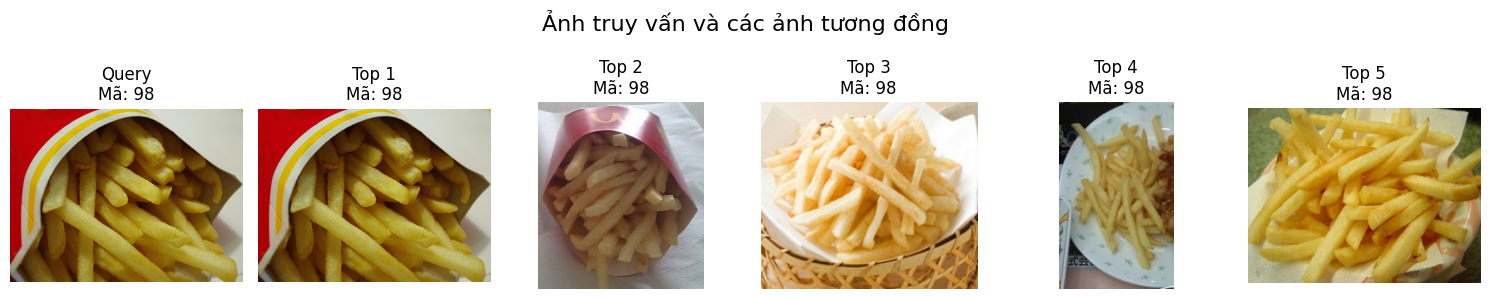

In [6]:
# === Main ===
if __name__ == "__main__":
    weight_path = "/kaggle/input/evalue-aftertrain/resnet50_triplet.pth"
    cropped_folder = "/kaggle/input/encoding-image-and-testing/cropped_images"

    model, device = load_trained_model(weight_path)
    vectors, image_names = encode_images_in_folder(model, device, cropped_folder)
    search_and_display(vectors, image_names, cropped_folder, query_idx=2, k=5)

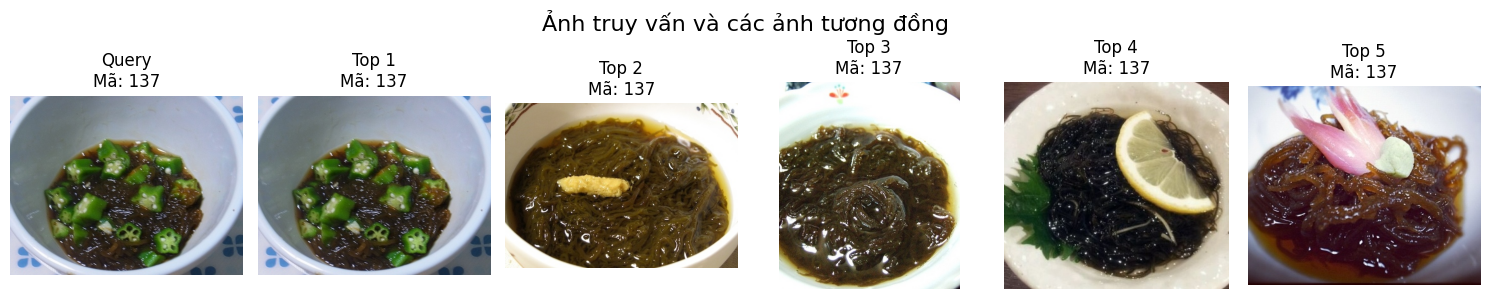

In [7]:
search_and_display(vectors, image_names, cropped_folder, query_idx=5, k=5)

In [8]:
import numpy as np
import faiss

# Tạo danh sách label từ tên ảnh
labels = np.array([int(name.split("_")[0]) for name in image_names])

# FAISS Index
d = vectors.shape[1]
index = faiss.IndexFlatIP(d)
faiss.normalize_L2(vectors)
index.add(vectors)

# Tìm kiếm với FAISS (k=6 để bỏ qua chính nó)
D, I = index.search(vectors, k=6)

top1_correct = 0
top5_correct = 0
total = len(vectors)

for i in range(total):
    query_label = labels[i]
    retrieved = I[i][1:6]  # bỏ chính nó, lấy top-5 ảnh gần nhất
    retrieved_labels = labels[retrieved]

    # Top-1 đúng nếu ảnh gần nhất (sau khi bỏ chính nó) có label đúng
    if retrieved_labels[0] == query_label:
        top1_correct += 1

    # Top-5 đúng nếu ít nhất 1 trong 5 ảnh có cùng label
    if query_label in retrieved_labels:
        top5_correct += 1

# Accuracy
top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Top-5 Accuracy: {top5_acc:.4f}")

✅ Top-1 Accuracy: 0.5297
✅ Top-5 Accuracy: 0.8144


In [9]:
# ==== Triplet Loss ====
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive)
    neg_dist = F.pairwise_distance(anchor, negative)
    return torch.relu(pos_dist - neg_dist + margin).mean()

# ==== Tiếp tục Train ====
def continue_training_model(weight_path, data_dir, batch_size=32, epochs=5, lr=1e-4, output_path="resnet50_triplet_continued.pth"):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = TripletDataset(data_dir, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EmbeddingNet().to(device)

    # Load model cũ
    model.load_state_dict(torch.load(weight_path, map_location=device))
    print("✅ Loaded pretrained weights from:", weight_path)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for anchor, pos, neg in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
            out_a = model(anchor)
            out_p = model(pos)
            out_n = model(neg)

            loss = triplet_loss(out_a, out_p, out_n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), output_path)
    print(f"📦 Model tiếp tục train đã được lưu tại: {output_path}")
    return model




In [10]:
# === Ví dụ sử dụng ===
if __name__ == "__main__":
    weight_path = "/kaggle/input/evalue-aftertrain/resnet50_triplet.pth"
    data_dir = "/kaggle/input/encoding-image-and-testing/cropped_images"
    continue_training_model(weight_path, data_dir,batch_size=54, epochs=60)

<ipython-input-9-205b30dd7347>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path, map_location=device))


✅ Loaded pretrained weights from: /kaggle/input/evalue-aftertrain/resnet50_triplet.pth


Epoch 1/60: 100%|██████████| 186/186 [05:08<00:00,  1.66s/it]


Epoch 1, Loss: 0.0685


Epoch 2/60: 100%|██████████| 186/186 [05:20<00:00,  1.73s/it]


Epoch 2, Loss: 0.0695


Epoch 3/60: 100%|██████████| 186/186 [05:05<00:00,  1.64s/it]


Epoch 3, Loss: 0.0714


Epoch 4/60: 100%|██████████| 186/186 [04:59<00:00,  1.61s/it]


Epoch 4, Loss: 0.0716


Epoch 5/60: 100%|██████████| 186/186 [05:05<00:00,  1.64s/it]


Epoch 5, Loss: 0.0711


Epoch 6/60: 100%|██████████| 186/186 [08:31<00:00,  2.75s/it]


Epoch 6, Loss: 0.0606


Epoch 7/60: 100%|██████████| 186/186 [06:42<00:00,  2.17s/it]


Epoch 7, Loss: 0.0646


Epoch 8/60: 100%|██████████| 186/186 [05:11<00:00,  1.67s/it]


Epoch 8, Loss: 0.0635


Epoch 9/60: 100%|██████████| 186/186 [04:52<00:00,  1.57s/it]


Epoch 9, Loss: 0.0643


Epoch 10/60: 100%|██████████| 186/186 [05:27<00:00,  1.76s/it]


Epoch 10, Loss: 0.0625


Epoch 11/60: 100%|██████████| 186/186 [05:33<00:00,  1.79s/it]


Epoch 11, Loss: 0.0632


Epoch 12/60: 100%|██████████| 186/186 [04:58<00:00,  1.60s/it]


Epoch 12, Loss: 0.0613


Epoch 13/60: 100%|██████████| 186/186 [05:19<00:00,  1.72s/it]


Epoch 13, Loss: 0.0628


Epoch 14/60: 100%|██████████| 186/186 [05:06<00:00,  1.65s/it]


Epoch 14, Loss: 0.0613


Epoch 15/60: 100%|██████████| 186/186 [05:26<00:00,  1.76s/it]


Epoch 15, Loss: 0.0636


Epoch 16/60: 100%|██████████| 186/186 [05:58<00:00,  1.93s/it]


Epoch 16, Loss: 0.0591


Epoch 17/60: 100%|██████████| 186/186 [07:49<00:00,  2.53s/it]


Epoch 17, Loss: 0.0673


Epoch 18/60: 100%|██████████| 186/186 [08:07<00:00,  2.62s/it]


Epoch 18, Loss: 0.0610


Epoch 19/60: 100%|██████████| 186/186 [11:07<00:00,  3.59s/it]


Epoch 19, Loss: 0.0641


Epoch 20/60: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]


Epoch 20, Loss: 0.0624


Epoch 21/60: 100%|██████████| 186/186 [05:31<00:00,  1.78s/it]


Epoch 21, Loss: 0.0585


Epoch 22/60: 100%|██████████| 186/186 [05:04<00:00,  1.64s/it]


Epoch 22, Loss: 0.0603


Epoch 23/60: 100%|██████████| 186/186 [06:01<00:00,  1.95s/it]


Epoch 23, Loss: 0.0600


Epoch 24/60: 100%|██████████| 186/186 [05:09<00:00,  1.67s/it]


Epoch 24, Loss: 0.0543


Epoch 25/60: 100%|██████████| 186/186 [05:08<00:00,  1.66s/it]


Epoch 25, Loss: 0.0549


Epoch 26/60: 100%|██████████| 186/186 [05:21<00:00,  1.73s/it]


Epoch 26, Loss: 0.0602


Epoch 27/60: 100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 27, Loss: 0.0570


Epoch 28/60: 100%|██████████| 186/186 [05:22<00:00,  1.73s/it]


Epoch 28, Loss: 0.0538


Epoch 29/60: 100%|██████████| 186/186 [07:26<00:00,  2.40s/it]


Epoch 29, Loss: 0.0558


Epoch 30/60: 100%|██████████| 186/186 [05:17<00:00,  1.71s/it]


Epoch 30, Loss: 0.0582


Epoch 31/60: 100%|██████████| 186/186 [05:08<00:00,  1.66s/it]


Epoch 31, Loss: 0.0516


Epoch 32/60: 100%|██████████| 186/186 [05:28<00:00,  1.76s/it]


Epoch 32, Loss: 0.0495


Epoch 33/60: 100%|██████████| 186/186 [05:54<00:00,  1.91s/it]


Epoch 33, Loss: 0.0542


Epoch 34/60: 100%|██████████| 186/186 [07:32<00:00,  2.43s/it]


Epoch 34, Loss: 0.0547


Epoch 35/60: 100%|██████████| 186/186 [04:59<00:00,  1.61s/it]


Epoch 35, Loss: 0.0516


Epoch 36/60: 100%|██████████| 186/186 [05:04<00:00,  1.64s/it]


Epoch 36, Loss: 0.0541


Epoch 37/60: 100%|██████████| 186/186 [05:25<00:00,  1.75s/it]


Epoch 37, Loss: 0.0531


Epoch 38/60: 100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 38, Loss: 0.0494


Epoch 39/60: 100%|██████████| 186/186 [05:22<00:00,  1.73s/it]


Epoch 39, Loss: 0.0481


Epoch 40/60: 100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 40, Loss: 0.0522


Epoch 41/60: 100%|██████████| 186/186 [05:04<00:00,  1.64s/it]


Epoch 41, Loss: 0.0498


Epoch 42/60: 100%|██████████| 186/186 [05:26<00:00,  1.76s/it]


Epoch 42, Loss: 0.0522


Epoch 43/60: 100%|██████████| 186/186 [05:25<00:00,  1.75s/it]


Epoch 43, Loss: 0.0509


Epoch 44/60: 100%|██████████| 186/186 [05:29<00:00,  1.77s/it]


Epoch 44, Loss: 0.0502


Epoch 45/60: 100%|██████████| 186/186 [05:32<00:00,  1.79s/it]


Epoch 45, Loss: 0.0471


Epoch 46/60: 100%|██████████| 186/186 [04:58<00:00,  1.61s/it]


Epoch 46, Loss: 0.0485


Epoch 47/60: 100%|██████████| 186/186 [05:10<00:00,  1.67s/it]


Epoch 47, Loss: 0.0484


Epoch 48/60: 100%|██████████| 186/186 [05:01<00:00,  1.62s/it]


Epoch 48, Loss: 0.0477


Epoch 49/60: 100%|██████████| 186/186 [04:56<00:00,  1.60s/it]


Epoch 49, Loss: 0.0494


Epoch 50/60: 100%|██████████| 186/186 [05:12<00:00,  1.68s/it]


Epoch 50, Loss: 0.0480


Epoch 51/60: 100%|██████████| 186/186 [05:06<00:00,  1.65s/it]


Epoch 51, Loss: 0.0484


Epoch 52/60: 100%|██████████| 186/186 [05:03<00:00,  1.63s/it]


Epoch 52, Loss: 0.0504


Epoch 53/60: 100%|██████████| 186/186 [05:08<00:00,  1.66s/it]


Epoch 53, Loss: 0.0452


Epoch 54/60: 100%|██████████| 186/186 [05:23<00:00,  1.74s/it]


Epoch 54, Loss: 0.0436


Epoch 55/60: 100%|██████████| 186/186 [05:18<00:00,  1.71s/it]


Epoch 55, Loss: 0.0454


Epoch 56/60: 100%|██████████| 186/186 [07:00<00:00,  2.26s/it]


Epoch 56, Loss: 0.0476


Epoch 57/60: 100%|██████████| 186/186 [05:57<00:00,  1.92s/it]


Epoch 57, Loss: 0.0465


Epoch 58/60: 100%|██████████| 186/186 [05:29<00:00,  1.77s/it]


Epoch 58, Loss: 0.0459


Epoch 59/60: 100%|██████████| 186/186 [05:17<00:00,  1.71s/it]


Epoch 59, Loss: 0.0450


Epoch 60/60: 100%|██████████| 186/186 [05:21<00:00,  1.73s/it]

Epoch 60, Loss: 0.0447
📦 Model tiếp tục train đã được lưu tại: resnet50_triplet_continued.pth
